<a href="https://colab.research.google.com/github/project-ida/nuclear/blob/master/02-internuclear-potentials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a> &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <a href="https://nbviewer.jupyter.org/github/project-ida/nuclear/blob/master/02-internuclear-potentials.ipynb" target="_parent"><img src="https://nbviewer.jupyter.org/static/img/nav_logo.svg" alt="Open In nbviewer" width="100"/></a>

# Internuclear potentials

This notebooks looks at different sections of the internuclear potential between two nuclei, specifically two deuterium nuclei as in the case of a molecule of deuterons D2. 

The three potentials considered are:
1. The Kolos & Wolniewicz numerical potential and the Morse potential
2. The Coulomb potential
3. The Woods-Saxon nuclear potential

## Loading libraries and helper functions

In [220]:
import pandas as pd
import numpy as np
#import plotly.express as px
#import plotly.graph_objects as go
from scipy.constants import pi, epsilon_0, e
from matplotlib import pyplot as plt

import dygraphs.graph as dy 

In [3]:
def bohr_to_pm(length):
    return length*5.292e-11*1e12

def pm_to_bohr(length):
    return length/(5.292e-11*1e12)

def hartree_to_ev(energy):
    return energy*27.211

## Kolos & Wolniewicz (KW): numerically determined interatomic potential

From Koonin & Nauenberg (KN) 1989: _"we have taken for the diatomic molecular potential V(r) the best available numerical calculation in the Born-Oppenheimer approximation, due to Kolos and Wolniewicz"_

The KW reference is (the numerically determined potential is given in Table III): 
> Kolos, W., & Wolniewicz, L. (1964). Accurate adiabatic treatment of the ground state of the hydrogen molecule. The Journal of Chemical Physics, 41, 3663–3673.

And KN 1989 describe further: _"For 1.1 < r < 3 this potential is well approximated by the Morse potential"_ (Note that 1.1 bohr = 58 pm and 3 bohr = 159 pm)

The Morse potential is a simple parameterized potential. It is usually given as: 

$$V(r)=D_{e}(e^{-2a(r-r_{e})}-2e^{-a(r-r_{e})})$$

In [235]:
kw = pd.read_csv("./data/k-w_potential.csv")

In [241]:
def morsepot_au(r): # in atomic units
    a = 0.4
    return (1+0.1745)*(np.exp(-2*a*(r-1.4))-2*np.exp(-a*(r-1.4))) 
    # I had to add +1 to the minimum energy and adjust a accordingly

In [242]:
kw["Rpm"] = bohr_to_pm(kw["R"]) # in metric units
kw["Eev"] = hartree_to_ev(kw["E"]) # in metric units

kw["Morseev"] = morsepot_au(kw["R"])

kw.head()

,R,alpha,E,V,Rpm,Eev,Morseev
0,0.40,0.407,-0.120203,-2.363029,21.168,-3.270838,-0.890398
1,0.45,0.416,-0.350928,-2.502431,23.814,-9.549107,-0.923501
2,0.50,0.442,-0.526627,-2.591787,26.460,-14.330047,-0.953959
3,0.55,0.4836,-0.662758,-2.646558,29.106,-18.034316,-0.981902
4,0.60,0.5223,-0.769625,-2.676960,31.752,-20.942274,-1.007456


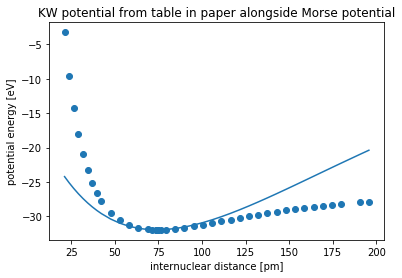

In [239]:
plt.scatter(kw["Rpm"],kw["Eev"])
plt.plot(kw["Rpm"],hartree_to_ev(kw["Morseev"]))
plt.xlabel("internuclear distance [pm]")
plt.ylabel("potential energy [eV]")
plt.title("KW potential from table in paper alongside Morse potential")
plt.show() 

The KW potential is given at irregular intervals. We'd like to interpolate and resample to a sampling rate of 0.1 pm across the 25 to 200 pm range. The result will be stored in dataframe kw_copy.

In [234]:
kw_copy = pd.DataFrame({'Rpm': kw["Rpm"], 'Eev': kw["Eev"]})
kw_copy.index = kw["Rpm"]

kw_new = pd.DataFrame({'Rpm': new_index, 'Eev': 0})
new_index = np.arange(25,200,0.1)
kw_new.index = new_index

kw_copy = kw_copy.reindex(kw_copy.index.union(kw_new.index))\
                 .interpolate(method='index')\
                 .reindex(kw_new.index)

kw_copy.head()

,Rpm,Eev
25.0,25.0,-11.692038
25.1,25.1,-11.872724
25.2,25.2,-12.053409
25.3,25.3,-12.234095
25.4,25.4,-12.414780


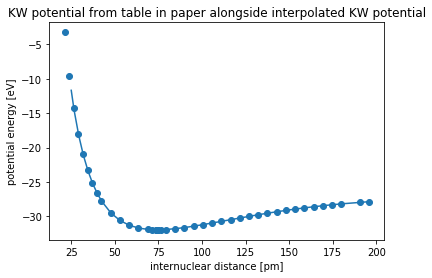

In [233]:
plt.scatter(kw["Rpm"],kw["Eev"])
plt.plot(kw_copy["Rpm"],kw_copy["Eev"])
plt.xlabel("internuclear distance [pm]")
plt.ylabel("potential energy [eV]")
plt.title("KW potential from table in paper alongside interpolated KW potential")
plt.show()

## Adding a Coulomb potential

As we get to closer proximities, the KW potential is no longer defined and the Coulomb potential which in the D2 case is essentially 1/r dominates.

It is not clear to me at this point how to merge the two potentials, especially near their intersection. KN 1989 write: _"For smaller values of r we fitted the calculated values of V - 1/r to a seven-term Lagrange interpolation formula."_

In [279]:
# when working in au then both e and the denominator except r are 1
def coulomb_au(Z_1,Z_2,r):
  U = Z_1*Z_2 / r
  return U

In [246]:
Rpm2 = np.arange(1,100,0.1)

Cev =  coulomb_au(1,1,pm_to_bohr(Rpm2)) - 1.9037 # subtract a constant according to K&N

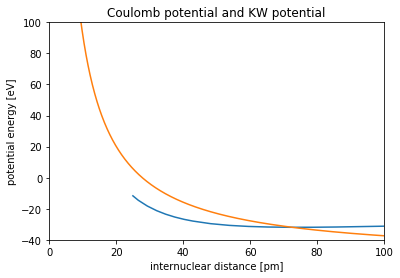

In [252]:
plt.plot(kw_copy["Rpm"],kw_copy["Eev"])
plt.plot(Rpm2,hartree_to_ev(Cev))

plt.ylim(-40,100)
plt.xlim(-0,100)
plt.xlabel("internuclear distance [pm]")
plt.ylabel("potential energy [eV]")
plt.title("Coulomb potential and KW potential")
plt.show()

## Adding a Woods-Saxon nuclear potential

The Woods-Saxon (WS) potential is a mean potential that is assumed to reasonably describe the attraction of the nuclear force from a given nucleus with A=number of nucleons.

In [119]:
A = 4 # 4 nucleons in two deuterium atoms
V0 = 28.5e6 #50 # ground state energy see for He-4 https://pdfs.semanticscholar.org/4c24/b2d33f3b3ca2f288897967dc3a6fdb51f1a0.pdf
a = 0.5e-15
r0 = 1.25e-15
R = r0*A**(0.3333)

def woodssaxon_ev(r, V0, R, a):
    return -V0/(1.0+np.exp((r-R)/a))

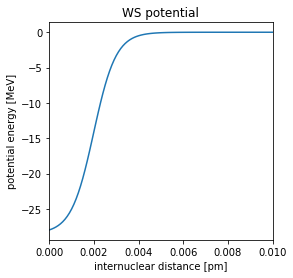

In [260]:
Rpm1 = np.arange(0.0,1,0.0001)

ws = woodssaxon_ev(Rpm1*1e-12, V0, R, a)

plt.figure(figsize=(4,4))
plt.plot(Rpm1, ws/1e6)
plt.xlim(0,0.01)

plt.xlabel("internuclear distance [pm]")
plt.ylabel("potential energy [MeV]")
plt.title("WS potential")
plt.show()

## Assembling it all

Finally, all three potentials are assembled in a single dataframe that covers the range of internuclear distances from 0.1 fm to 100 pm. 

In [270]:
rpm_all = np.concatenate((Rpm1,Rpm2))

fullpotential = pd.DataFrame({'Rpm': rpm_all, 'WSev': 0, 'Cev': 0, 'KWev': 0})

In [271]:
thisr = fullpotential.loc[fullpotential["Rpm"] < 1,"Rpm"]
thisr
thisws = woodssaxon_ev(thisr*1e-12, V0, R, a)
thisws

fullpotential.loc[fullpotential["Rpm"] < 1,"WSev"] = thisws

In [272]:
thisr = fullpotential.loc[(fullpotential["Rpm"] > 0.0005) & (fullpotential["Rpm"] < 25.0),"Rpm"]
thisr
thisc = hartree_to_ev(energyau(1,1,pm_to_bohr(thisr)) - 1.9037)
thisc

fullpotential.loc[thisc.index,"Cev"] = thisc

(0, 0.01)

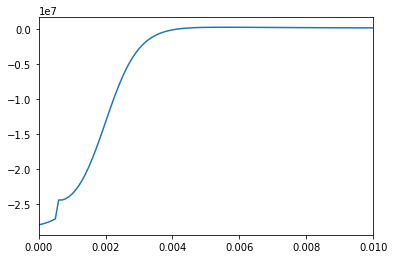

In [273]:
plt.plot(fullpotential["Rpm"],fullpotential["WSev"]+fullpotential["Cev"])
plt.xlim(0,0.01)

In [276]:
fullpotential["Rpm"] = np.round(fullpotential["Rpm"],4)
kw_copy["Rpm"] = np.round(kw_copy["Rpm"],4)

fullpotential = pd.merge(fullpotential, kw_copy, on='Rpm', how='outer')
fullpotential = fullpotential.fillna(0)
fullpotential

,Rpm,WSev,Cev,KWev,Eev_x,Eev_y,Eev
0,0.0000,-2.797120e+07,0.0,0.0,0.000000,0.000000,0.000000
1,0.0001,-2.785676e+07,0.0,0.0,0.000000,0.000000,0.000000
2,0.0002,-2.771826e+07,0.0,0.0,0.000000,0.000000,0.000000
3,0.0003,-2.755094e+07,0.0,0.0,0.000000,0.000000,0.000000
4,0.0004,-2.734930e+07,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...
80865,195.8040,0.000000e+00,0.0,0.0,-27.874246,-27.874246,-27.874246
80866,195.8040,0.000000e+00,0.0,0.0,-27.874246,-27.874246,-27.874246
80867,195.8040,0.000000e+00,0.0,0.0,-27.874246,-27.874246,-27.874246
80868,195.8040,0.000000e+00,0.0,0.0,-27.874246,-27.874246,-27.874246


In [277]:
fullpotential["assembled"] = fullpotential["WSev"]+fullpotential["Cev"]+fullpotential["Eev"]

In [278]:
# Create a figure
fig = dy.figure(width = 600, height = 400)

# Generate data for the plot
x = fullpotential["Rpm"]
y = [fullpotential["assembled"]]

# Plot the data on the figure
fig.plot(x,y)

# Show the figure in this cell of the notebook
fig.show()

""
""
